# Finding Gravitational Waves!


### Part A:

First want to come up with a noise model.

In [79]:
import h5py
import numpy as np
import scipy.signal.windows as wind
import matplotlib.pyplot as plt
from matplotlib import rcParams

#From LIGO website
import readligo as rl

In [90]:
rcParams['figure.figsize'] = (12,8)

In [16]:
template_fn = './LOSC_Event_tutorial/GW150914_4_template.hdf5'
data_fn = './LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5'

In [103]:
strain, time, chan_dict = rl.loaddata(data_fn)
dt = time[1]-time[0]
dnu = 1.0/(dt*len(time))
sampling_rate = 1.0/dt

In [115]:
dat_ft = np.abs(np.fft.rfft(strain))
ps = dat_ft**2
nu = np.arange(len(datft))*dnu #Why does this work? Just puts you in Frequency domain I guess

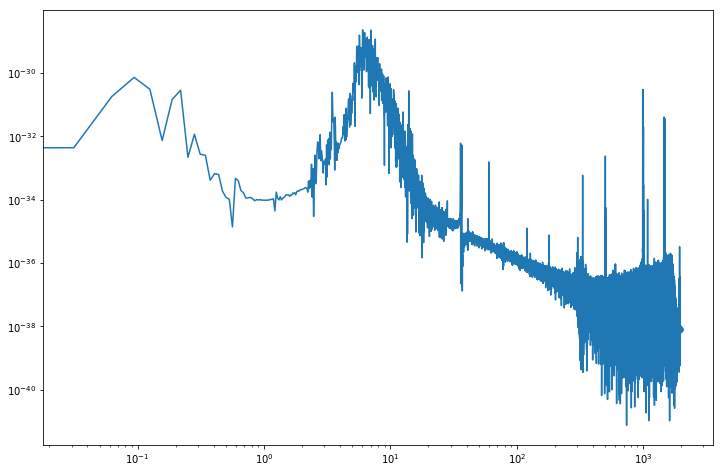

In [116]:
#plt.figure()
plt.loglog(nu,ps)
plt.show()

Make a window function. What might a good choice be? Referencing the windows on https://en.wikipedia.org/wiki/Window_function, going to use the Nuttal window as its fourier transform has low power in the sidelobes.

In [122]:
window = wind.nuttall(len(strain))

dat_ft_w = abs(np.fft.rfft(window*strain)) #What really is the difference between rfft and irfft?
ps_w = dat_ft_w**2

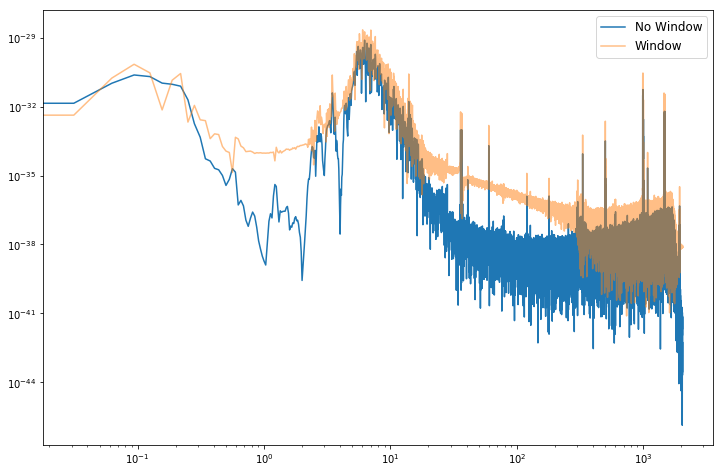

In [124]:
plt.loglog(nu,ps_w,label='No Window')
plt.loglog(nu,ps,alpha=0.5,label='Window')
plt.legend(fontsize='large')
plt.show()